# Sanity check snATAC-seq data
- Checking scRNA-seq part same as step1_qc/rna/qc_rna.ipynb

## Set up correct conda environment

In [1]:
.libPaths()

[1] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

In [2]:
.libPaths('/home/groups/tttt/xjluo/miniconda3/envs/single_cell/lib/R/library')
.libPaths()

[1] "/home/groups/tttt/xjluo/miniconda3/envs/single_cell/lib/R/library"
[2] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

In [3]:
library(tidyverse)
library(viridis)
library(Seurat)
library(Signac)
library(Azimuth)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ggpointdensity)
library(ggExtra)

set.seed(1234)
options(repr.matrix.max.cols=100, repr.matrix.max.rows=50)
options(warn=-1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk'

In [4]:
sample <- 'V'

In [5]:
# value is either 'ALL' or 'GFP' depending on the script
all_or_gfp <- 'ALL'

## STEP 0: Paths

In [6]:
data_master_dir <- '/oak/stanford/groups/tttt/collaboration/jin/231220_ATAC/cellranger'

data_master_dir

[1] "/oak/stanford/groups/tttt/collaboration/jin/231220_ATAC/cellranger"

In [7]:
rna_path <- paste0(data_master_dir, '/xjluo_analysis/step1_qc/', 'RNA', '/', 'RNA.both.conditions.annotated.Seurat.v4.rds')

rna_path

[1] "/oak/stanford/groups/tttt/collaboration/jin/231220_ATAC/cellranger/xjluo_analysis/step1_qc/RNA/RNA.both.conditions.annotated.Seurat.v4.rds"

In [8]:
atac_dir <- '/oak/stanford/groups/tttt/collaboration/jin/231220_ATAC/cellranger/xjluo_analysis/step1_qc/ATAC'
atac_path <- paste0(atac_dir, '/2_filtered_objects/', sample, ".ATAC.filtered.Seurat.v4.rds")

atac_path

[1] "/oak/stanford/groups/tttt/collaboration/jin/231220_ATAC/cellranger/xjluo_analysis/step1_qc/ATAC/2_filtered_objects/V.ATAC.filtered.Seurat.v4.rds"

## STEP 1: Load data

In [9]:
# RNA
rna.obj.annotated.Seurat.v4 <- readRDS(rna_path)

print(rna.obj.annotated.Seurat.v4)

show(table(rna.obj.annotated.Seurat.v4$orig.ident))

An object of class Seurat 
52425 features across 5489 samples within 2 assays 
Active assay: SCT (20140 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, rna_only_UMAP

 all  GFP 
2444 3045 


In [10]:
# ATAC

atac.obj.annotated.Seurat.v4 <- readRDS(atac_path)

atac.obj.annotated.Seurat.v4

An object of class Seurat 
208404 features across 965 samples within 1 assay 
Active assay: ATAC (208404 features, 208403 variable features)
 2 dimensional reductions calculated: lsi, umap

### Inspect objects

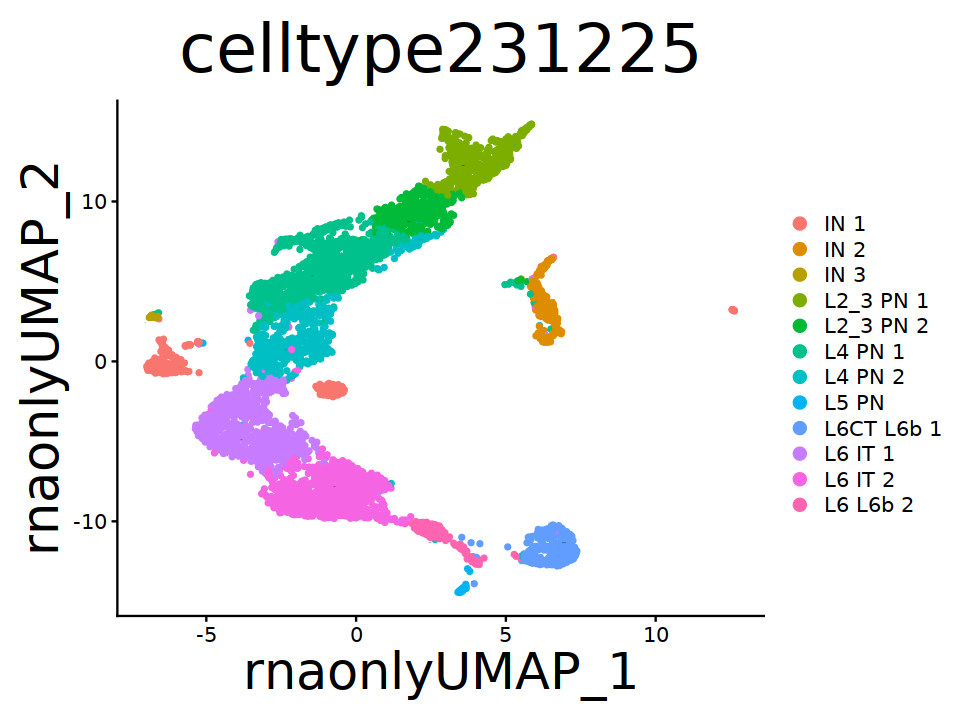

In [11]:
# RNA
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(rna.obj.annotated.Seurat.v4, shuffle=TRUE, label = TRUE, repel = TRUE, pt.size=1, label.size=0, reduction = "rna_only_UMAP", group.by = 'celltype231225', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     
     


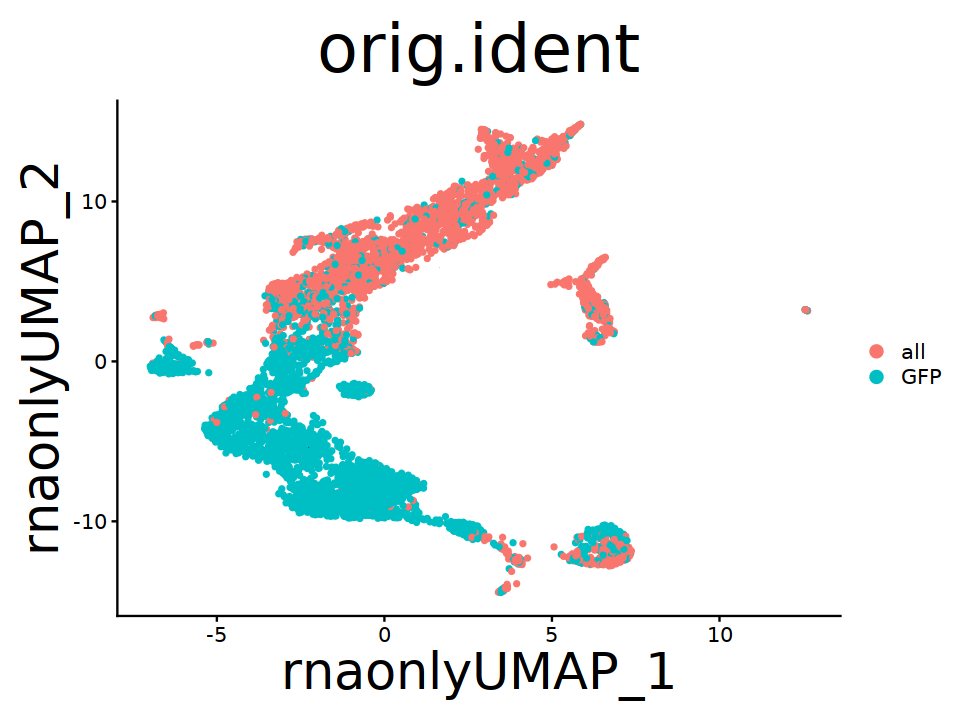

In [12]:
# RNA
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(rna.obj.annotated.Seurat.v4, shuffle=TRUE, label = TRUE, repel = TRUE, pt.size=1, label.size=0, reduction = "rna_only_UMAP", group.by = 'orig.ident', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     
     


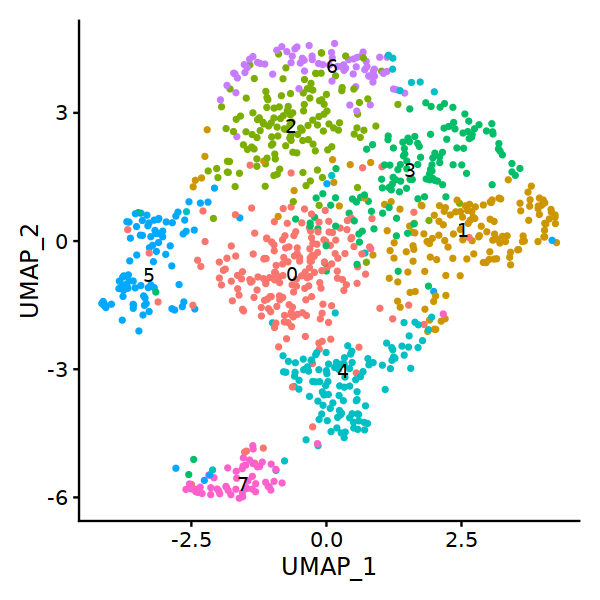

In [13]:
# ATAC
options(repr.plot.width=5, repr.plot.height=5)

DimPlot(object = atac.obj.annotated.Seurat.v4, label = TRUE) + NoLegend()

## STEP 2: Check gene accessibility (snATAC-seq)

In [14]:
DefaultAssay(atac.obj.annotated.Seurat.v4) <- 'ATAC'
gene.activities.all.genes <- GeneActivity(atac.obj.annotated.Seurat.v4)

Extracting gene coordinates

Extracting reads overlapping genomic regions



In [15]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
atac.obj.annotated.Seurat.v4[['RNA_all']] <- CreateAssayObject(counts = gene.activities.all.genes)
atac.obj.annotated.Seurat.v4 <- NormalizeData(
  object = atac.obj.annotated.Seurat.v4,
  assay = 'RNA_all',
  normalization.method = 'LogNormalize',
  scale.factor = median(atac.obj.annotated.Seurat.v4$nCount_RNA_all)
)

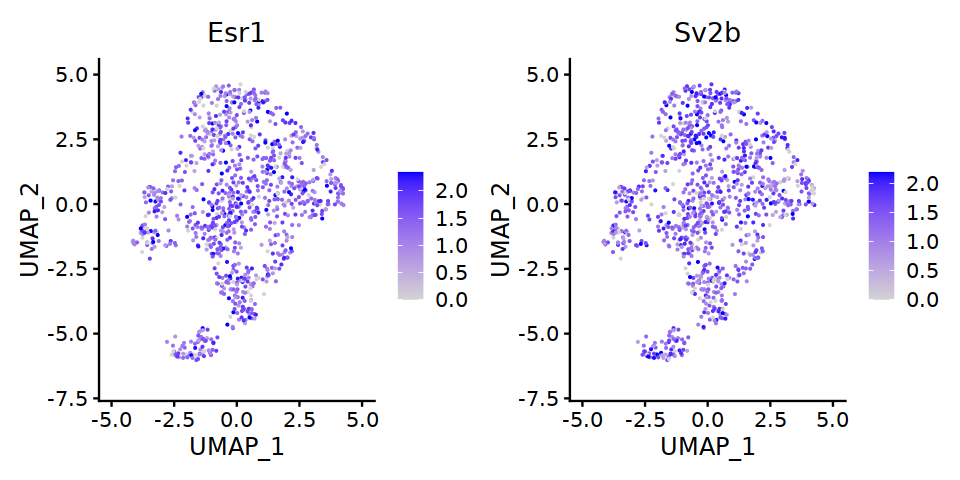

In [16]:
options(repr.plot.width=8, repr.plot.height=4)

DefaultAssay(atac.obj.annotated.Seurat.v4) <- 'RNA_all'

FeaturePlot(
  object = atac.obj.annotated.Seurat.v4,
  features = c('Esr1', 'Sv2b'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 2
)

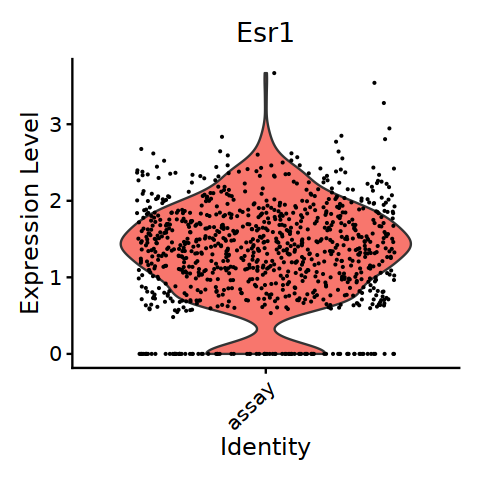

In [17]:
DefaultAssay(atac.obj.annotated.Seurat.v4) <- 'RNA_all'
Idents(atac.obj.annotated.Seurat.v4) <- 'assay'
options(repr.plot.width=4, repr.plot.height=4)

VlnPlot(
  object = atac.obj.annotated.Seurat.v4,
  features = c('Esr1'),
  pt.size = 0.1
) + theme(legend.position="none")

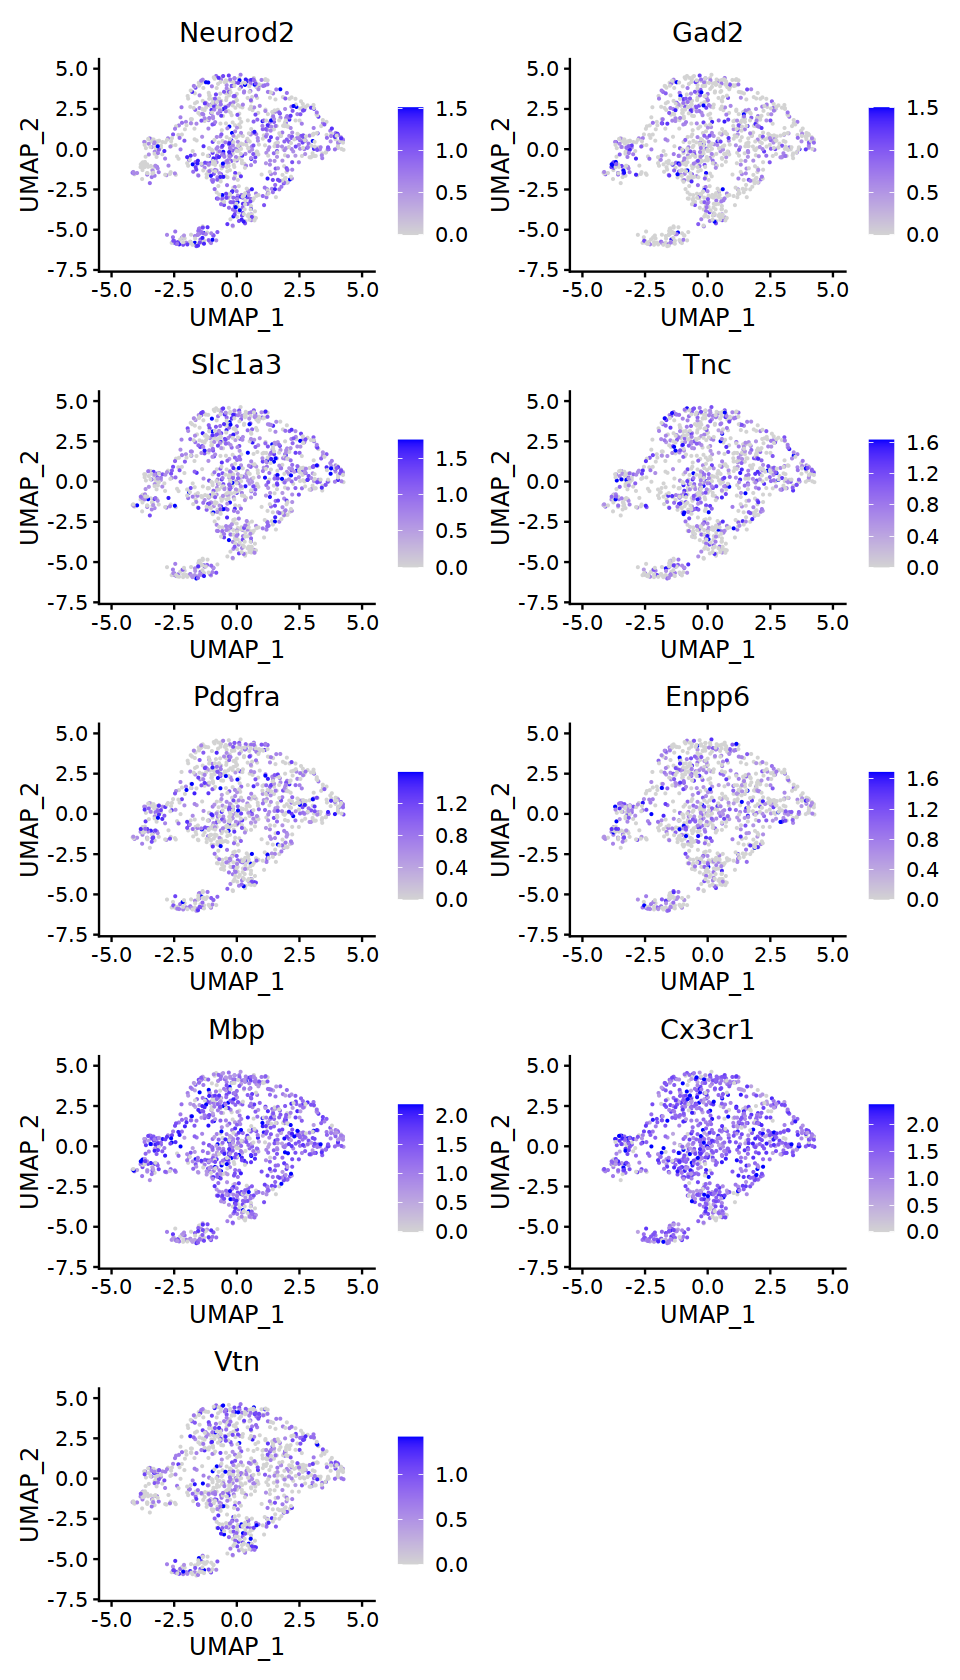

In [18]:
options(repr.plot.width=8, repr.plot.height=14)

DefaultAssay(atac.obj.annotated.Seurat.v4) <- 'RNA_all'

FeaturePlot(
  object = atac.obj.annotated.Seurat.v4,
  features = c("Meg3",
              "Neurod2",
              "Gad2",
              "Slc1a3",
              "Tnc",
              "Pdgfra",
              "Enpp6",
              "Mbp",
              "Cx3cr1",
              "Vtn"
              ),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 2
)

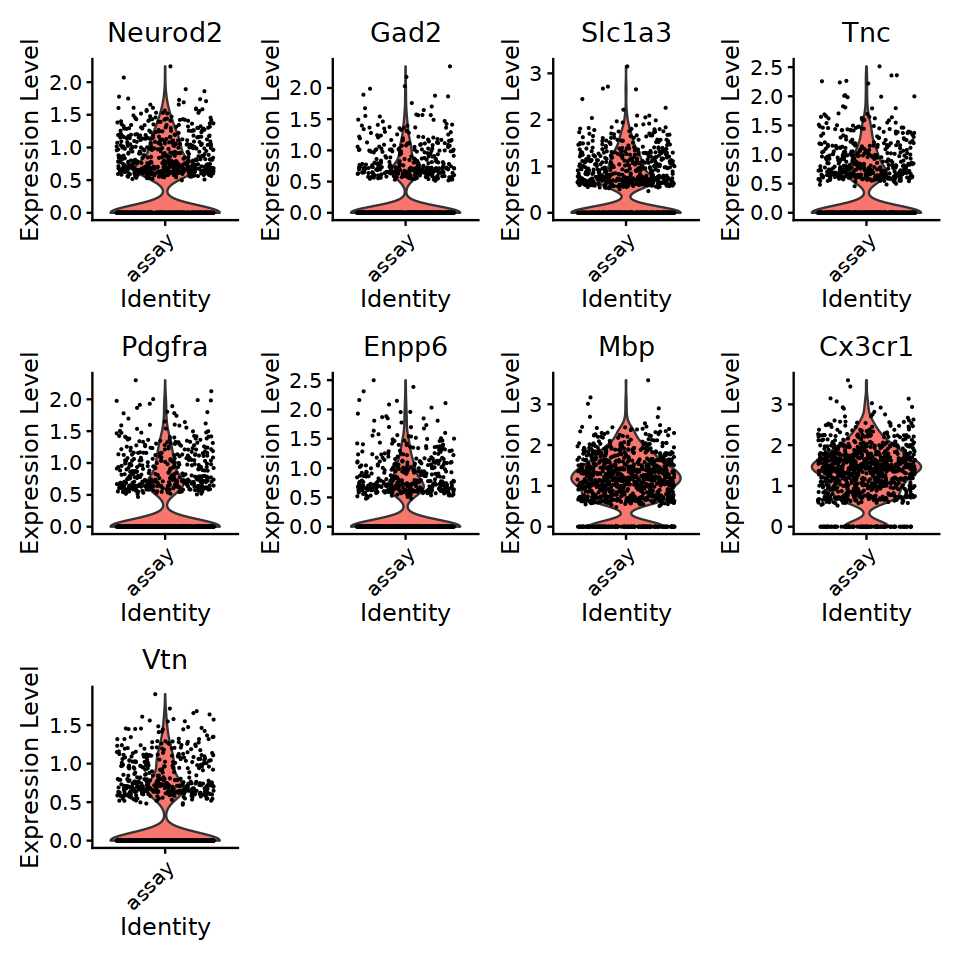

In [19]:
DefaultAssay(atac.obj.annotated.Seurat.v4) <- 'RNA_all'
Idents(atac.obj.annotated.Seurat.v4) <- 'assay'
options(repr.plot.width=8, repr.plot.height=8)

VlnPlot(
  object = atac.obj.annotated.Seurat.v4,
  features = c("Meg3",
              "Neurod2",
              "Gad2",
              "Slc1a3",
              "Tnc",
              "Pdgfra",
              "Enpp6",
              "Mbp",
              "Cx3cr1",
              "Vtn"
              ),
  pt.size = 0.1
) + theme(legend.position="none")


# Tan et al., Cell (2021)
# https://www.sciencedirect.com/science/article/pii/S0092867420317542

In [20]:
dim(GetAssayData(atac.obj.annotated.Seurat.v4, assay = 'RNA_all', slot = 'data'))

[1] 21808   965

## STEP 2: Check gene expression (scRNA-seq)

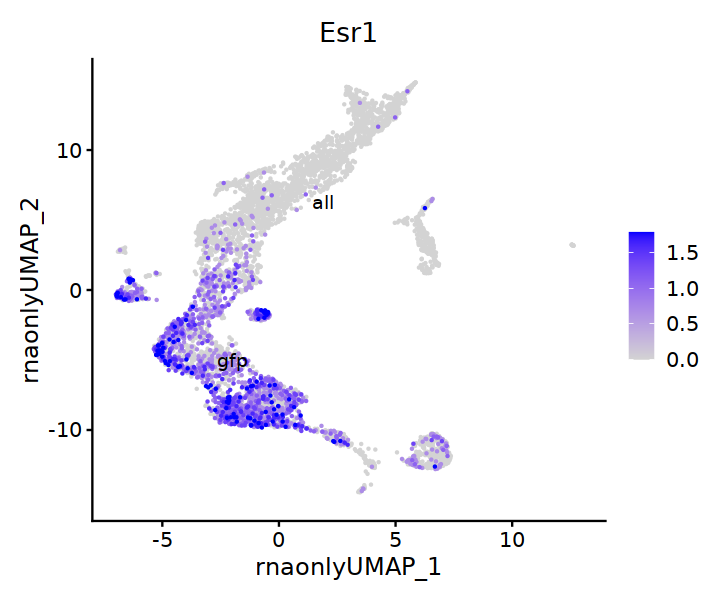

In [21]:
options(repr.plot.width=6, repr.plot.height=5)
DefaultAssay(rna.obj.annotated.Seurat.v4) <- "SCT"

FeaturePlot(
  object = rna.obj.annotated.Seurat.v4,
  features = c("Esr1"),
  pt.size = 0.2,
  label.size = 4,
  max.cutoff = 'q95',
  ncol = 1,
  reduction = "rna_only_UMAP",
  label = TRUE,
  raster = FALSE,
  order = TRUE
)

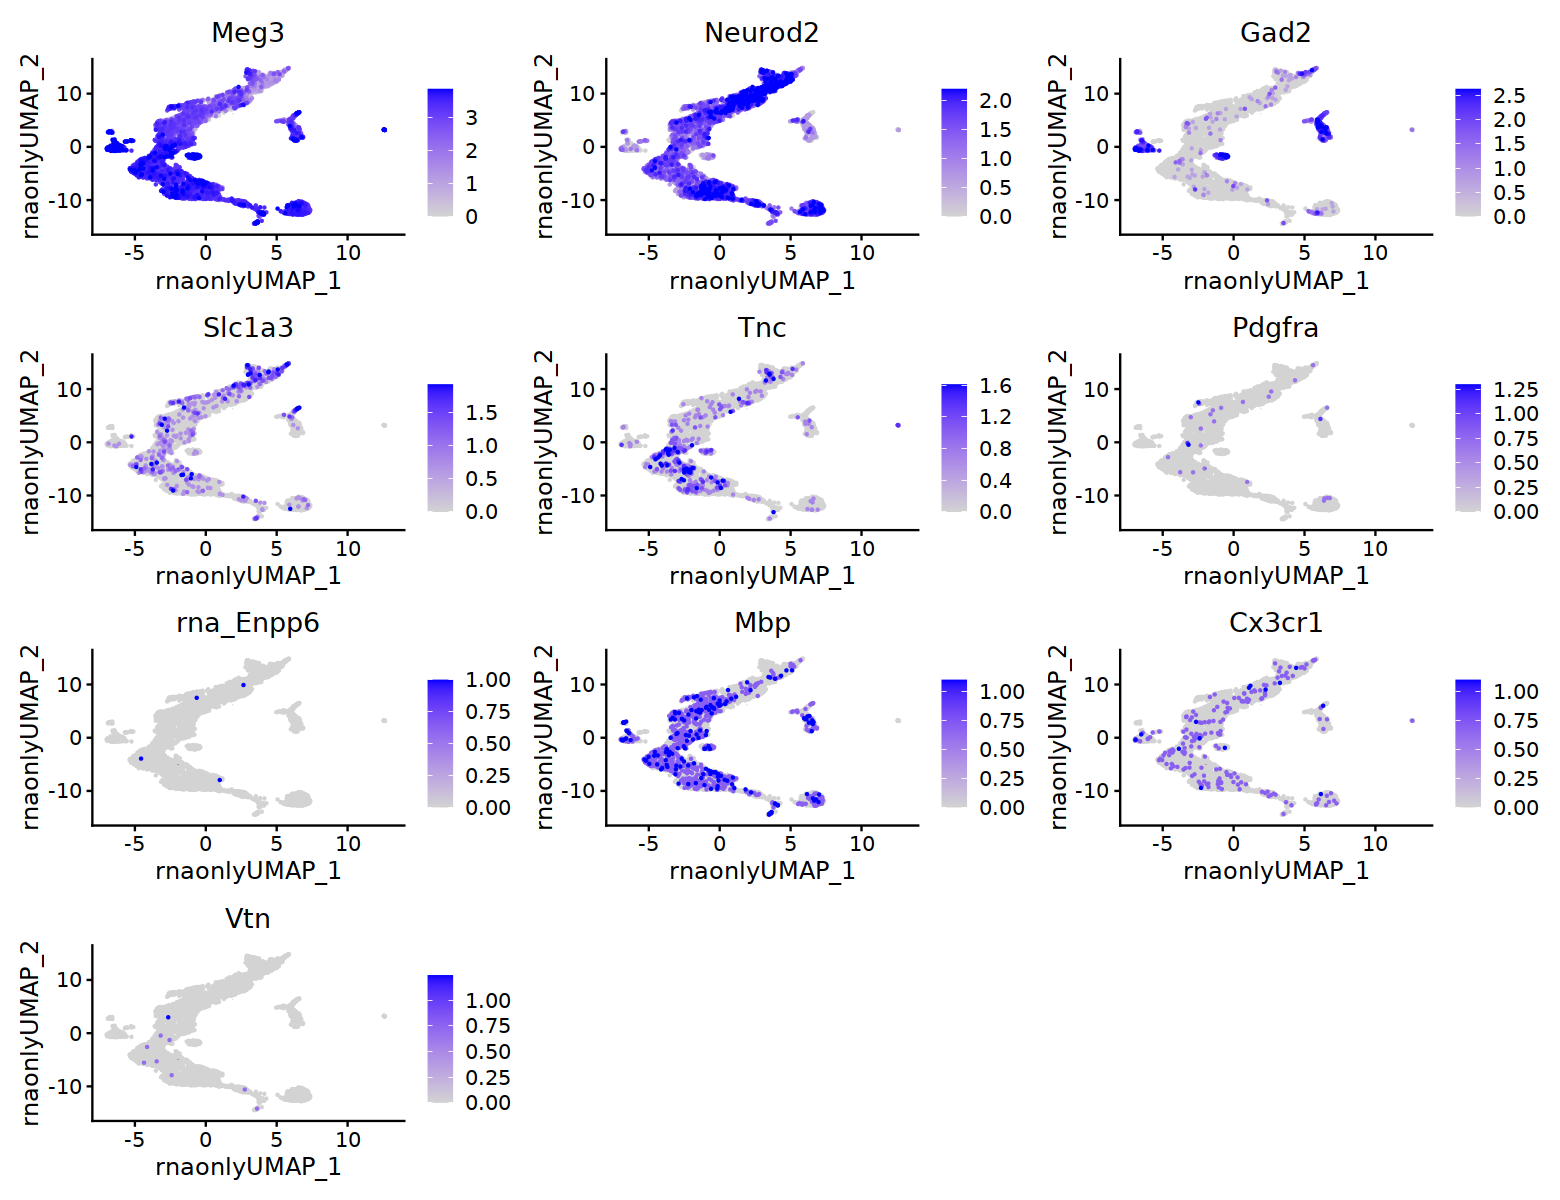

In [22]:
options(repr.plot.width=13, repr.plot.height=10)
DefaultAssay(rna.obj.annotated.Seurat.v4) <- "SCT"

FeaturePlot(
  object = rna.obj.annotated.Seurat.v4,
  features = c("Meg3",
              "Neurod2",
              "Gad2",
              "Slc1a3",
              "Tnc",
              "Pdgfra",
              "Enpp6",
              "Mbp",
              "Cx3cr1",
              "Vtn"
              ),
  pt.size = 0.2,
  label.size = 0,
  max.cutoff = 'q95',
  ncol = 3,
  reduction = "rna_only_UMAP",
  label = TRUE,
  raster = FALSE,
  order = TRUE
)


# Tan et al., Cell (2021)
# https://www.sciencedirect.com/science/article/pii/S0092867420317542

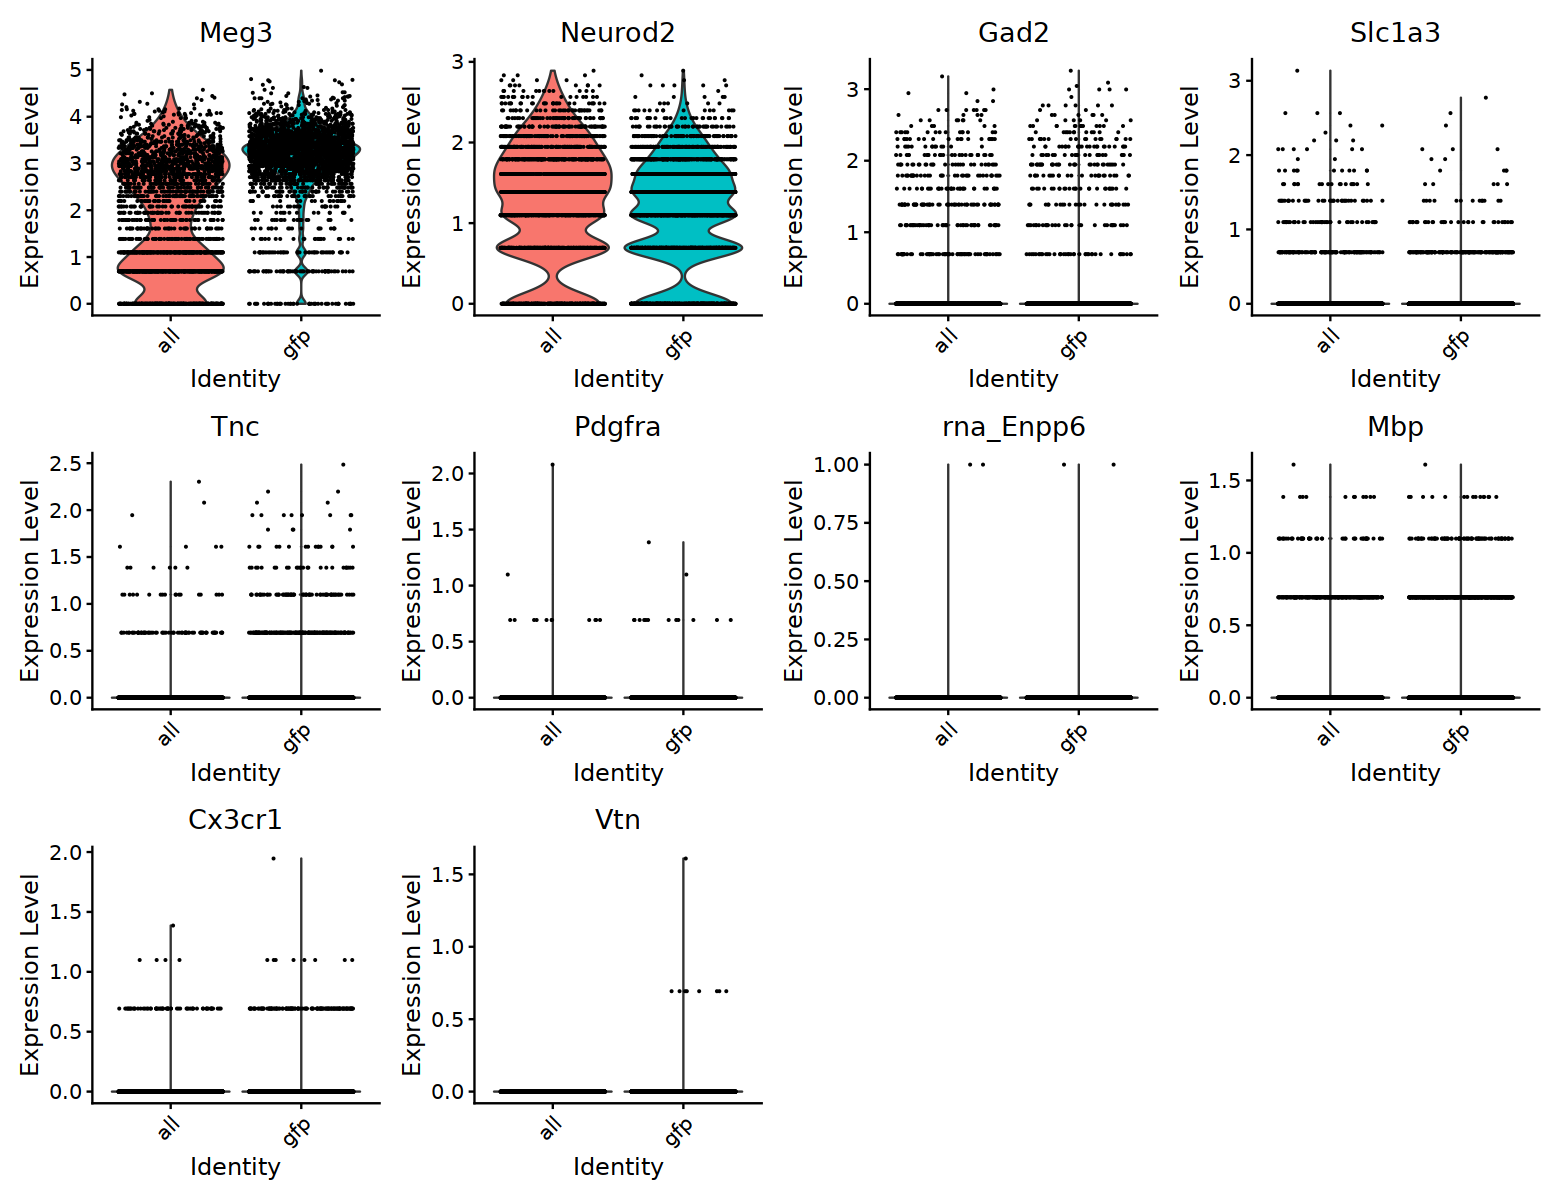

In [23]:
options(repr.plot.width=13, repr.plot.height=10)
DefaultAssay(rna.obj.annotated.Seurat.v4) <- "SCT"

VlnPlot(rna.obj.annotated.Seurat.v4, features = c("Meg3",
              "Neurod2",
              "Gad2",
              "Slc1a3",
              "Tnc",
              "Pdgfra",
              "Enpp6",
              "Mbp",
              "Cx3cr1",
              "Vtn"
              ))

# END